## End To End Project architecture

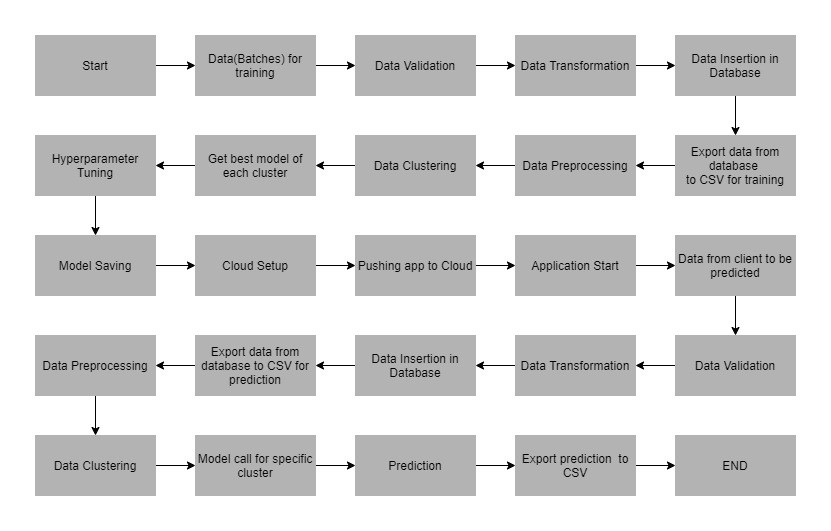

In [23]:
from IPython.display import Image
Image(filename='D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/project architecture.jpg')

## Logging

In [24]:
from datetime import datetime


class App_Logger:
    def __init__(self):
        pass

    def log(self, file_object, log_message):
        self.now = datetime.now()
        self.date = self.now.date()
        self.current_time = self.now.strftime("%H:%M:%S")
        file_object.write(
            str(self.date) + "/" + str(self.current_time) + "\t\t" + log_message +"\n")

## Training data validation

In [3]:
from datetime import datetime
#from Training_Raw_data_validation.rawValidation import Raw_Data_validation
#from DataTypeValidation_Insertion_Training.DataTypeValidation import dBOperation
#from DataTransform_Training.DataTransformation import dataTransform
#from application_logging import logger

class train_validation:
    def __init__(self,path):
        self.raw_data = Raw_Data_validation(path)
        self.dataTransform = dataTransform()
        self.dBOperation = dBOperation()
        self.file_object = open("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Training_Logs/Training_Main_Log.txt", 'a+')
        self.log_writer = App_Logger()

    def train_validation(self):
        try:
            self.log_writer.log(self.file_object, 'Start of Validation on files for prediction!!')
            # extracting values from prediction schema
            LengthOfDateStampInFile, LengthOfTimeStampInFile, column_names, noofcolumns = self.raw_data.valuesFromSchema()
            # getting the regex defined to validate filename
            regex = self.raw_data.manualRegexCreation()
            # validating filename of prediction files
            self.raw_data.validationFileNameRaw(regex, LengthOfDateStampInFile, LengthOfTimeStampInFile)
            # validating column length in the file
            self.raw_data.validateColumnLength(noofcolumns)
            # validating if any column has all values missing
            self.raw_data.validateMissingValuesInWholeColumn()
            self.log_writer.log(self.file_object, "Raw Data Validation Complete!!")

            self.log_writer.log(self.file_object, "Starting Data Transforamtion!!")
            # replacing blanks in the csv file with "Null" values to insert in table
            self.dataTransform.addQuotesToStringValuesInColumn()

            self.log_writer.log(self.file_object, "DataTransformation Completed!!!")

            self.log_writer.log(self.file_object,
                                "Creating Training_Database and tables on the basis of given schema!!!")
            # create database with given name, if present open the connection! Create table with columns given in schema
            self.dBOperation.createTableDb('Training', column_names)
            self.log_writer.log(self.file_object, "Table creation Completed!!")
            self.log_writer.log(self.file_object, "Insertion of Data into Table started!!!!")
            # insert csv files in the table
            self.dBOperation.insertIntoTableGoodData('Training')
            self.log_writer.log(self.file_object, "Insertion in Table completed!!!")
            self.log_writer.log(self.file_object, "Deleting Good Data Folder!!!")
            # Delete the good data folder after loading files in table
            self.raw_data.deleteExistingGoodDataTrainingFolder()
            self.log_writer.log(self.file_object, "Good_Data folder deleted!!!")
            self.log_writer.log(self.file_object, "Moving bad files to Archive and deleting Bad_Data folder!!!")
            # Move the bad files to archive folder
            self.raw_data.moveBadFilesToArchiveBad()
            self.log_writer.log(self.file_object, "Bad files moved to archive!! Bad folder Deleted!!")
            self.log_writer.log(self.file_object, "Validation Operation completed!!")
            self.log_writer.log(self.file_object, "Extracting csv file from table")
            # export data in table to csvfile
            self.dBOperation.selectingDatafromtableintocsv('Training')
            self.file_object.close()

        except Exception as e:
            raise e


In [4]:
import sqlite3
from datetime import datetime
from os import listdir
import os
import re
import json
import shutil
import pandas as pd
#from application_logging.logger import App_Logger





class Raw_Data_validation:

    """
             This class shall be used for handling all the validation done on the Raw Training Data!!.

             Written By: iNeuron Intelligence
             Version: 1.0
             Revisions: None

             """

    def __init__(self,path):
        self.Batch_Directory = path
        self.schema_path = 'D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/schema_training.json'
        self.logger = App_Logger()


    def valuesFromSchema(self):
        """
                        Method Name: valuesFromSchema
                        Description: This method extracts all the relevant information from the pre-defined "Schema" file.
                        Output: LengthOfDateStampInFile, LengthOfTimeStampInFile, column_names, Number of Columns
                        On Failure: Raise ValueError,KeyError,Exception

                         Written By: iNeuron Intelligence
                        Version: 1.0
                        Revisions: None

                                """
        try:
            with open(self.schema_path, 'r') as f:
                dic = json.load(f)
                f.close()
            pattern = dic['SampleFileName']
            LengthOfDateStampInFile = dic['LengthOfDateStampInFile']
            LengthOfTimeStampInFile = dic['LengthOfTimeStampInFile']
            column_names = dic['ColName']
            NumberofColumns = dic['NumberofColumns']

            file = open("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Training_Logs/valuesfromSchemaValidationLog.txt", 'a+')
            message ="LengthOfDateStampInFile:: %s" %LengthOfDateStampInFile + "\t" + "LengthOfTimeStampInFile:: %s" % LengthOfTimeStampInFile +"\t " + "NumberofColumns:: %s" % NumberofColumns + "\n"
            self.logger.log(file,message)

            file.close()



        except ValueError:
            file = open("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Training_Logs/valuesfromSchemaValidationLog.txt", 'a+')
            self.logger.log(file,"ValueError:Value not found inside schema_training.json")
            file.close()
            raise ValueError

        except KeyError:
            file = open("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Training_Logs/valuesfromSchemaValidationLog.txt", 'a+')
            self.logger.log(file, "KeyError:Key value error incorrect key passed")
            file.close()
            raise KeyError

        except Exception as e:
            file = open("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Training_Logs/valuesfromSchemaValidationLog.txt", 'a+')
            self.logger.log(file, str(e))
            file.close()
            raise e

        return LengthOfDateStampInFile, LengthOfTimeStampInFile, column_names, NumberofColumns


    def manualRegexCreation(self):
        """
                                Method Name: manualRegexCreation
                                Description: This method contains a manually defined regex based on the "FileName" given in "Schema" file.
                                            This Regex is used to validate the filename of the training data.
                                Output: Regex pattern
                                On Failure: None

                                 Written By: iNeuron Intelligence
                                Version: 1.0
                                Revisions: None

                                        """
        regex = "['hypothyroid']+['\_'']+[\d_]+[\d]+\.csv"
        return regex

    def createDirectoryForGoodBadRawData(self):

        """
                                      Method Name: createDirectoryForGoodBadRawData
                                      Description: This method creates directories to store the Good Data and Bad Data
                                                    after validating the training data.

                                      Output: None
                                      On Failure: OSError

                                       Written By: iNeuron Intelligence
                                      Version: 1.0
                                      Revisions: None

                                              """

        try:
            path = os.path.join("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Training_Raw_files_validated/", "Good_Raw/")
            if not os.path.isdir(path):
                os.makedirs(path)
            path = os.path.join("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Training_Raw_files_validated/", "Bad_Raw/")
            if not os.path.isdir(path):
                os.makedirs(path)

        except OSError as ex:
            file = open("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Training_Logs/GeneralLog.txt", 'a+')
            self.logger.log(file,"Error while creating Directory %s:" % ex)
            file.close()
            raise OSError

    def deleteExistingGoodDataTrainingFolder(self):

        """
                                            Method Name: deleteExistingGoodDataTrainingFolder
                                            Description: This method deletes the directory made  to store the Good Data
                                                          after loading the data in the table. Once the good files are
                                                          loaded in the DB,deleting the directory ensures space optimization.
                                            Output: None
                                            On Failure: OSError

                                             Written By: iNeuron Intelligence
                                            Version: 1.0
                                            Revisions: None

                                                    """

        try:
            path = 'D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Training_Raw_files_validated/'
            # if os.path.isdir("ids/" + userName):
            # if os.path.isdir(path + 'Bad_Raw/'):
            #     shutil.rmtree(path + 'Bad_Raw/')
            if os.path.isdir(path + 'Good_Raw/'):
                shutil.rmtree(path + 'Good_Raw/')
                file = open("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Training_Logs/GeneralLog.txt", 'a+')
                self.logger.log(file,"GoodRaw directory deleted successfully!!!")
                file.close()
        except OSError as s:
            file = open("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Training_Logs/GeneralLog.txt", 'a+')
            self.logger.log(file,"Error while Deleting Directory : %s" %s)
            file.close()
            raise OSError

    def deleteExistingBadDataTrainingFolder(self):

        """
                                            Method Name: deleteExistingBadDataTrainingFolder
                                            Description: This method deletes the directory made to store the bad Data.
                                            Output: None
                                            On Failure: OSError

                                             Written By: iNeuron Intelligence
                                            Version: 1.0
                                            Revisions: None

                                                    """

        try:
            path = 'D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Training_Raw_files_validated/'
            if os.path.isdir(path + 'Bad_Raw/'):
                shutil.rmtree(path + 'Bad_Raw/')
                file = open("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Training_Logs/GeneralLog.txt", 'a+')
                self.logger.log(file,"BadRaw directory deleted before starting validation!!!")
                file.close()
        except OSError as s:
            file = open("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Training_Logs/GeneralLog.txt", 'a+')
            self.logger.log(file,"Error while Deleting Directory : %s" %s)
            file.close()
            raise OSError

    def moveBadFilesToArchiveBad(self):

        """
                                            Method Name: moveBadFilesToArchiveBad
                                            Description: This method deletes the directory made  to store the Bad Data
                                                          after moving the data in an archive folder. We archive the bad
                                                          files to send them back to the client for invalid data issue.
                                            Output: None
                                            On Failure: OSError

                                             Written By: iNeuron Intelligence
                                            Version: 1.0
                                            Revisions: None

                                                    """
        now = datetime.now()
        date = now.date()
        time = now.strftime("%H%M%S")
        try:

            source = 'D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Training_Raw_files_validated/Bad_Raw/'
            if os.path.isdir(source):
                path = "D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/TrainingArchiveBadData"
                if not os.path.isdir(path):
                    os.makedirs(path)
                dest = 'D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/TrainingArchiveBadData/BadData_' + str(date)+"_"+str(time)
                if not os.path.isdir(dest):
                    os.makedirs(dest)
                files = os.listdir(source)
                for f in files:
                    if f not in os.listdir(dest):
                        shutil.move(source + f, dest)
                file = open("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Training_Logs/GeneralLog.txt", 'a+')
                self.logger.log(file,"Bad files moved to archive")
                path = 'D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Training_Raw_files_validated/'
                if os.path.isdir(path + 'Bad_Raw/'):
                    shutil.rmtree(path + 'Bad_Raw/')
                self.logger.log(file,"Bad Raw Data Folder Deleted successfully!!")
                file.close()
        except Exception as e:
            file = open("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Training_Logs/GeneralLog.txt", 'a+')
            self.logger.log(file, "Error while moving bad files to archive:: %s" % e)
            file.close()
            raise e




    def validationFileNameRaw(self,regex,LengthOfDateStampInFile,LengthOfTimeStampInFile):
        """
                    Method Name: validationFileNameRaw
                    Description: This function validates the name of the training csv files as per given name in the schema!
                                 Regex pattern is used to do the validation.If name format do not match the file is moved
                                 to Bad Raw Data folder else in Good raw data.
                    Output: None
                    On Failure: Exception

                     Written By: iNeuron Intelligence
                    Version: 1.0
                    Revisions: None

                """

        #pattern = "['Wafer']+['\_'']+[\d_]+[\d]+\.csv"
        # delete the directories for good and bad data in case last run was unsuccessful and folders were not deleted.
        self.deleteExistingBadDataTrainingFolder()
        self.deleteExistingGoodDataTrainingFolder()
        #create new directories
        self.createDirectoryForGoodBadRawData()
        onlyfiles = [f for f in listdir(self.Batch_Directory)]
        try:
            f = open("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Training_Logs/nameValidationLog.txt", 'a+')
            for filename in onlyfiles:
                if (re.match(regex, filename)):
                    splitAtDot = re.split('.csv', filename)
                    splitAtDot = (re.split('_', splitAtDot[0]))
                    if len(splitAtDot[1]) == LengthOfDateStampInFile:
                        if len(splitAtDot[2]) == LengthOfTimeStampInFile:
                            shutil.copy("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Training_Batch_Files/" + filename, "D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Training_Raw_files_validated/Good_Raw")
                            self.logger.log(f,"Valid File name!! File moved to GoodRaw Folder :: %s" % filename)

                        else:
                            shutil.copy("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Training_Batch_Files/" + filename, "D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Training_Raw_files_validated/Bad_Raw")
                            self.logger.log(f,"Invalid File Name!! File moved to Bad Raw Folder :: %s" % filename)
                    else:
                        shutil.copy("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Training_Batch_Files/" + filename, "D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Training_Raw_files_validated/Bad_Raw")
                        self.logger.log(f,"Invalid File Name!! File moved to Bad Raw Folder :: %s" % filename)
                else:
                    shutil.copy("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Training_Batch_Files/" + filename, "D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Training_Raw_files_validated/Bad_Raw")
                    self.logger.log(f, "Invalid File Name!! File moved to Bad Raw Folder :: %s" % filename)

            f.close()

        except Exception as e:
            f = open("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Training_Logs/nameValidationLog.txt", 'a+')
            self.logger.log(f, "Error occured while validating FileName %s" % e)
            f.close()
            raise e




    def validateColumnLength(self,NumberofColumns):
        """
                          Method Name: validateColumnLength
                          Description: This function validates the number of columns in the csv files.
                                       It is should be same as given in the schema file.
                                       If not same file is not suitable for processing and thus is moved to Bad Raw Data folder.
                                       If the column number matches, file is kept in Good Raw Data for processing.
                                      The csv file is missing the first column name, this function changes the missing name to "Wafer".
                          Output: None
                          On Failure: Exception

                           Written By: iNeuron Intelligence
                          Version: 1.0
                          Revisions: None

                      """
        try:
            f = open("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Training_Logs/columnValidationLog.txt", 'a+')
            self.logger.log(f,"Column Length Validation Started!!")
            for file in listdir('D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Training_Raw_files_validated/Good_Raw/'):
                csv = pd.read_csv("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Training_Raw_files_validated/Good_Raw/" + file)
                if csv.shape[1] == NumberofColumns:
                    pass
                else:
                    shutil.move("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Training_Raw_files_validated/Good_Raw/" + file, "D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Training_Raw_files_validated/Bad_Raw")
                    self.logger.log(f, "Invalid Column Length for the file!! File moved to Bad Raw Folder :: %s" % file)
            self.logger.log(f, "Column Length Validation Completed!!")
        except OSError:
            f = open("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Training_Logs/columnValidationLog.txt", 'a+')
            self.logger.log(f, "Error Occured while moving the file :: %s" % OSError)
            f.close()
            raise OSError
        except Exception as e:
            f = open("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Training_Logs/columnValidationLog.txt", 'a+')
            self.logger.log(f, "Error Occured:: %s" % e)
            f.close()
            raise e
        f.close()

    def validateMissingValuesInWholeColumn(self):
        """
                                  Method Name: validateMissingValuesInWholeColumn
                                  Description: This function validates if any column in the csv file has all values missing.
                                               If all the values are missing, the file is not suitable for processing.
                                               SUch files are moved to bad raw data.
                                  Output: None
                                  On Failure: Exception

                                   Written By: iNeuron Intelligence
                                  Version: 1.0
                                  Revisions: None

                              """
        try:
            f = open("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Training_Logs/missingValuesInColumn.txt", 'a+')
            self.logger.log(f,"Missing Values Validation Started!!")

            for file in listdir('D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Training_Raw_files_validated/Good_Raw/'):
                csv = pd.read_csv("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Training_Raw_files_validated/Good_Raw/" + file)
                count = 0
                for columns in csv:
                    if (len(csv[columns]) - csv[columns].count()) == len(csv[columns]):
                        count+=1
                        shutil.move("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Training_Raw_files_validated/Good_Raw/" + file,
                                    "D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Training_Raw_files_validated/Bad_Raw")
                        self.logger.log(f,"Invalid Column Length for the file!! File moved to Bad Raw Folder :: %s" % file)
                        break
                if count==0:
                    csv.rename(columns={"Unnamed: 0": "Wafer"}, inplace=True)
                    csv.to_csv("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Training_Raw_files_validated/Good_Raw/" + file, index=None, header=True)
        except OSError:
            f = open("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Training_Logs/missingValuesInColumn.txt", 'a+')
            self.logger.log(f, "Error Occured while moving the file :: %s" % OSError)
            f.close()
            raise OSError
        except Exception as e:
            f = open("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Training_Logs/missingValuesInColumn.txt", 'a+')
            self.logger.log(f, "Error Occured:: %s" % e)
            f.close()
            raise e
        f.close()


In [5]:
from datetime import datetime
from os import listdir
#from application_logging.logger import App_Logger
import pandas as pd


class dataTransform:
    

              
               #This class shall be used for transforming the Good Raw Training Data before loading it in Database!!.

               #Written By: iNeuron Intelligence
               #Version: 1.0
               #Revisions: None

               

    def __init__(self):
        
        self.goodDataPath = "D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Training_Raw_files_validated/Good_Raw"
        self.logger = App_Logger()


    def addQuotesToStringValuesInColumn(self):
        
        
          
        """                                Method Name: addQuotesToStringValuesInColumn
                                           Description: This method converts all the columns with string datatype such that
                                                       each value for that column is enclosed in quotes. This is done
                                                       to avoid the error while inserting string values in table as varchar.

                                            Written By: iNeuron Intelligence
                                           Version: 1.0
                                           Revisions: None"""

                                                   

        log_file = open("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Training_Logs/addQuotesToStringValuesInColumn.txt", 'a+')
        try:
            onlyfiles = [f for f in listdir(self.goodDataPath)]
            for file in onlyfiles:
                data = pd.read_csv(self.goodDataPath+"/" + file)
                #list of columns with string datatype variables
                column = ['sex', 'on_thyroxine', 'query_on_thyroxine', 'on_antithyroid_medication', 'sick', 'pregnant',
                           'thyroid_surgery', 'I131_treatment', 'query_hypothyroid', 'query_hyperthyroid', 'lithium',
                           'goitre', 'tumor', 'hypopituitary', 'psych', 'TSH_measured', 'T3_measured', 'TT4_measured',
                           'T4U_measured', 'FTI_measured', 'TBG_measured', 'TBG', 'referral_source', 'Class']

                for col in data.columns:
                        if col in column: # add quotes in string value
                            data[col] = data[col].apply(lambda x: "'" + str(x) + "'")
                        if col not in column: # add quotes to '?' values in integer/float columns
                            data[col] = data[col].replace('?', "'?'")
                    # #csv.update("'"+ csv['Wafer'] +"'")
                    # csv.update(csv['Wafer'].astype(str))
                    #csv['Wafer'] = csv['Wafer'].str[6:]
                data.to_csv(self.goodDataPath+ "/" + file, index=None, header=True)
                self.logger.log(log_file," %s: Quotes added successfully!!" % file)
               #log_file.write("Current Date :: %s" %date +"\t" + "Current time:: %s" % current_time + "\t \t" +  + "\n")
        except Exception as e:
            self.logger.log(log_file, "Data Transformation failed because:: %s" % e)
            #log_file.write("Current Date :: %s" %date +"\t" +"Current time:: %s" % current_time + "\t \t" + "Data Transformation failed because:: %s" % e + "\n")
            log_file.close()
        log_file.close()


In [6]:
import shutil
import sqlite3
from datetime import datetime
from os import listdir
import os
import csv
#from application_logging.logger import App_Logger


class dBOperation:
    """
      This class shall be used for handling all the SQL operations.

      Written By: iNeuron Intelligence
      Version: 1.0
      Revisions: None

      """
    def __init__(self):
        self.path = 'D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Training_Database/'
        self.badFilePath = "D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Training_Raw_files_validated/Bad_Raw"
        self.goodFilePath = "D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Training_Raw_files_validated/Good_Raw"
        self.logger = App_Logger()


    def dataBaseConnection(self,DatabaseName):

        """
                Method Name: dataBaseConnection
                Description: This method creates the database with the given name and if Database already exists then opens the connection to the DB.
                Output: Connection to the DB
                On Failure: Raise ConnectionError

                 Written By: iNeuron Intelligence
                Version: 1.0
                Revisions: None

                """
        try:
            conn = sqlite3.connect(self.path+DatabaseName+'.db')

            file = open("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Training_Logs/DataBaseConnectionLog.txt", 'a+')
            self.logger.log(file, "Opened %s database successfully" % DatabaseName)
            file.close()
        except ConnectionError:
            file = open("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Training_Logs/DataBaseConnectionLog.txt", 'a+')
            self.logger.log(file, "Error while connecting to database: %s" %ConnectionError)
            file.close()
            raise ConnectionError
        return conn

    def createTableDb(self,DatabaseName,column_names):
        """
                        Method Name: createTableDb
                        Description: This method creates a table in the given database which will be used to insert the Good data after raw data validation.
                        Output: None
                        On Failure: Raise Exception

                         Written By: iNeuron Intelligence
                        Version: 1.0
                        Revisions: None

                        """
        try:
            conn = self.dataBaseConnection(DatabaseName)
            c=conn.cursor()
            c.execute("SELECT count(name)  FROM sqlite_master WHERE type = 'table'AND name = 'Good_Raw_Data'")
            if c.fetchone()[0] ==1:
                conn.close()
                file = open("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Training_Logs/DbTableCreateLog.txt", 'a+')
                self.logger.log(file, "Tables created successfully!!")
                file.close()

                file = open("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Training_Logs/DataBaseConnectionLog.txt", 'a+')
                self.logger.log(file, "Closed %s database successfully" % DatabaseName)
                file.close()

            else:

                for key in column_names.keys():
                    type = column_names[key]

                    #in try block we check if the table exists, if yes then add columns to the table
                    # else in catch block we will create the table
                    try:
                        #cur = cur.execute("SELECT name FROM {dbName} WHERE type='table' AND name='Good_Raw_Data'".format(dbName=DatabaseName))
                        conn.execute('ALTER TABLE Good_Raw_Data ADD COLUMN "{column_name}" {dataType}'.format(column_name=key,dataType=type))
                    except:
                        conn.execute('CREATE TABLE  Good_Raw_Data ({column_name} {dataType})'.format(column_name=key, dataType=type))


                    # try:
                    #     #cur.execute("SELECT name FROM {dbName} WHERE type='table' AND name='Bad_Raw_Data'".format(dbName=DatabaseName))
                    #     conn.execute('ALTER TABLE Bad_Raw_Data ADD COLUMN "{column_name}" {dataType}'.format(column_name=key,dataType=type))
                    #
                    # except:
                    #     conn.execute('CREATE TABLE Bad_Raw_Data ({column_name} {dataType})'.format(column_name=key, dataType=type))


                conn.close()

                file = open("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Training_Logs/DbTableCreateLog.txt", 'a+')
                self.logger.log(file, "Tables created successfully!!")
                file.close()

                file = open("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Training_Logs/DataBaseConnectionLog.txt", 'a+')
                self.logger.log(file, "Closed %s database successfully" % DatabaseName)
                file.close()

        except Exception as e:
            file = open("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Training_Logs/DbTableCreateLog.txt", 'a+')
            self.logger.log(file, "Error while creating table: %s " % e)
            file.close()
            conn.close()
            file = open("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Training_Logs/DataBaseConnectionLog.txt", 'a+')
            self.logger.log(file, "Closed %s database successfully" % DatabaseName)
            file.close()
            raise e


    def insertIntoTableGoodData(self,Database):

        """
                               Method Name: insertIntoTableGoodData
                               Description: This method inserts the Good data files from the Good_Raw folder into the
                                            above created table.
                               Output: None
                               On Failure: Raise Exception

                                Written By: iNeuron Intelligence
                               Version: 1.0
                               Revisions: None

        """

        conn = self.dataBaseConnection(Database)
        goodFilePath= self.goodFilePath
        badFilePath = self.badFilePath
        onlyfiles = [f for f in listdir(goodFilePath)]
        log_file = open("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Training_Logs/DbInsertLog.txt", 'a+')

        for file in onlyfiles:
            try:
                with open(goodFilePath+'/'+file, "r") as f:
                    next(f)
                    reader = csv.reader(f, delimiter="\n")
                    for line in enumerate(reader):
                        for list_ in (line[1]):
                            try:
                                conn.execute('INSERT INTO Good_Raw_Data values ({values})'.format(values=(list_)))
                                self.logger.log(log_file," %s: File loaded successfully!!" % file)
                                conn.commit()
                            except Exception as e:
                                raise e

            except Exception as e:

                conn.rollback()
                self.logger.log(log_file,"Error while creating table: %s " % e)
                shutil.move(goodFilePath+'/' + file, badFilePath)
                self.logger.log(log_file, "File Moved Successfully %s" % file)
                log_file.close()
                conn.close()

        conn.close()
        log_file.close()


    def selectingDatafromtableintocsv(self,Database):

        """
                               Method Name: selectingDatafromtableintocsv
                               Description: This method exports the data in GoodData table as a CSV file. in a given location.
                                            above created .
                               Output: None
                               On Failure: Raise Exception

                                Written By: iNeuron Intelligence
                               Version: 1.0
                               Revisions: None

        """

        self.fileFromDb = 'D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Training_FileFromDB/'
        self.fileName = 'InputFile.csv'
        log_file = open("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Training_Logs/ExportToCsv.txt", 'a+')
        try:
            conn = self.dataBaseConnection(Database)
            sqlSelect = "SELECT *  FROM Good_Raw_Data"
            cursor = conn.cursor()

            cursor.execute(sqlSelect)

            results = cursor.fetchall()
            # Get the headers of the csv file
            headers = [i[0] for i in cursor.description]

            #Make the CSV ouput directory
            if not os.path.isdir(self.fileFromDb):
                os.makedirs(self.fileFromDb)

            # Open CSV file for writing.
            csvFile = csv.writer(open(self.fileFromDb + self.fileName, 'w', newline=''),delimiter=',', lineterminator='\r\n',quoting=csv.QUOTE_ALL, escapechar='\\')

            # Add the headers and data to the CSV file.
            csvFile.writerow(headers)
            csvFile.writerows(results)

            self.logger.log(log_file, "File exported successfully!!!")
            log_file.close()

        except Exception as e:
            self.logger.log(log_file, "File exporting failed. Error : %s" %e)
            log_file.close()


## Training model

In [7]:
"""
This is the Entry point for Training the Machine Learning Model.

Written By: iNeuron Intelligence
Version: 1.0
Revisions: None

"""


# Doing the necessary imports
from sklearn.model_selection import train_test_split
#from data_ingestion import data_loader
#from data_preprocessing import preprocessing
#from data_preprocessing import clustering
#from best_model_finder import tuner
#from file_operations import file_methods
#from application_logging import logger

#Creating the common Logging object


class trainModel:

    def __init__(self):
        self.log_writer = App_Logger()
        self.file_object = open("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Training_Logs/ModelTrainingLog.txt", 'a+')
    def trainingModel(self):
        # Logging the start of Training
        self.log_writer.log(self.file_object, 'Start of Training')
        try:
            # Getting the data from the source
            data_getter=Data_Getter(self.file_object,self.log_writer)
            data=data_getter.get_data()


            """doing the data preprocessing"""

            preprocessor=Preprocessor(self.file_object,self.log_writer)
            #data=preprocessor.remove_columns(data,['Wafer']) # remove the unnamed column as it doesn't contribute to prediction.

            #removing unwanted columns as discussed in the EDA part in ipynb file
            data = preprocessor.dropUnnecessaryColumns(data,['TSH_measured','T3_measured','TT4_measured','T4U_measured','FTI_measured','TBG_measured','TBG','TSH'])

            #repalcing '?' values with np.nan as discussed in the EDA part

            data = preprocessor.replaceInvalidValuesWithNull(data)

            # get encoded values for categorical data

            data = preprocessor.encodeCategoricalValues(data)

            # create separate features and labels
            X,Y=preprocessor.separate_label_feature(data,label_column_name='Class')

            # check if missing values are present in the dataset
            is_null_present=preprocessor.is_null_present(X)


            # if missing values are there, replace them appropriately.
            if(is_null_present):
                X=preprocessor.impute_missing_values(X) # missing value imputation

            X,Y = preprocessor.handleImbalanceDataset(X,Y)
            # check further which columns do not contribute to predictions
            # if the standard deviation for a column is zero, it means that the column has constant values
            # and they are giving the same output both for good and bad sensors
            # prepare the list of such columns to drop

            #cols_to_drop=preprocessor.get_columns_with_zero_std_deviation(X)

            # drop the columns obtained above
            #X=preprocessor.remove_columns(X,cols_to_drop)

            """ Applying the clustering approach"""

            kmeans=KMeansClustering(self.file_object,self.log_writer) # object initialization.
            number_of_clusters=kmeans.elbow_plot(X)  #  using the elbow plot to find the number of optimum clusters

            # Divide the data into clusters
            X=kmeans.create_clusters(X,number_of_clusters)

            #create a new column in the dataset consisting of the corresponding cluster assignments.
            X['Labels']=Y

            # getting the unique clusters from our dataset
            list_of_clusters=X['Cluster'].unique()

            """parsing all the clusters and looking for the best ML algorithm to fit on individual cluster"""

            for i in list_of_clusters:
                cluster_data=X[X['Cluster']==i] # filter the data for one cluster

                # Prepare the feature and Label columns
                cluster_features=cluster_data.drop(['Labels','Cluster'],axis=1)
                cluster_label= cluster_data['Labels']

                # splitting the data into training and test set for each cluster one by one
                x_train, x_test, y_train, y_test = train_test_split(cluster_features, cluster_label, test_size=1 / 3, random_state=355)

                model_finder=Model_Finder(self.file_object,self.log_writer) # object initialization

                #getting the best model for each of the clusters
                best_model_name,best_model=model_finder.get_best_model(x_train,y_train,x_test,y_test)

                #saving the best model to the directory.
                file_op = File_Operation(self.file_object,self.log_writer)
                save_model=file_op.save_model(best_model,best_model_name+str(i))

            # logging the successful Training
            self.log_writer.log(self.file_object, 'Successful End of Training')
            self.file_object.close()

        except Exception:
            # logging the unsuccessful Training
            self.log_writer.log(self.file_object, 'Unsuccessful End of Training')
            self.file_object.close()
            raise Exception

In [8]:
import pandas as pd

class Data_Getter:
    """
    This class shall  be used for obtaining the data from the source for training.

    Written By: iNeuron Intelligence
    Version: 1.0
    Revisions: None

    """
    def __init__(self, file_object, logger_object):
        self.training_file='D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Training_FileFromDB/InputFile.csv'
        self.file_object=file_object
        self.logger_object=logger_object

    def get_data(self):
        """
        Method Name: get_data
        Description: This method reads the data from source.
        Output: A pandas DataFrame.
        On Failure: Raise Exception

         Written By: iNeuron Intelligence
        Version: 1.0
        Revisions: None

        """
        self.logger_object.log(self.file_object,'Entered the get_data method of the Data_Getter class')
        try:
            self.data= pd.read_csv(self.training_file) # reading the data file
            self.logger_object.log(self.file_object,'Data Load Successful.Exited the get_data method of the Data_Getter class')
            return self.data
        except Exception as e:
            self.logger_object.log(self.file_object,'Exception occured in get_data method of the Data_Getter class. Exception message: '+str(e))
            self.logger_object.log(self.file_object,
                                   'Data Load Unsuccessful.Exited the get_data method of the Data_Getter class')
            raise Exception()


In [9]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from kneed import KneeLocator
#from file_operations import file_methods

class KMeansClustering:
    """
            This class shall  be used to divide the data into clusters before training.

            Written By: iNeuron Intelligence
            Version: 1.0
            Revisions: None

            """

    def __init__(self, file_object, logger_object):
        self.file_object = file_object
        self.logger_object = logger_object

    def elbow_plot(self,data):
        """
                        Method Name: elbow_plot
                        Description: This method saves the plot to decide the optimum number of clusters to the file.
                        Output: A picture saved to the directory
                        On Failure: Raise Exception

                        Written By: iNeuron Intelligence
                        Version: 1.0
                        Revisions: None

                """
        self.logger_object.log(self.file_object, 'Entered the elbow_plot method of the KMeansClustering class')
        wcss=[] # initializing an empty list
        try:
            for i in range (1,11):
                kmeans=KMeans(n_clusters=i,init='k-means++',random_state=42) # initializing the KMeans object
                kmeans.fit(data) # fitting the data to the KMeans Algorithm
                wcss.append(kmeans.inertia_)
            plt.plot(range(1,11),wcss) # creating the graph between WCSS and the number of clusters
            plt.title('The Elbow Method')
            plt.xlabel('Number of clusters')
            plt.ylabel('WCSS')
            #plt.show()
            plt.savefig('D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/preprocessing_data/K-Means_Elbow.PNG') # saving the elbow plot locally
            # finding the value of the optimum cluster programmatically
            self.kn = KneeLocator(range(1, 11), wcss, curve='convex', direction='decreasing')
            self.logger_object.log(self.file_object, 'The optimum number of clusters is: '+str(self.kn.knee)+' . Exited the elbow_plot method of the KMeansClustering class')
            return self.kn.knee

        except Exception as e:
            self.logger_object.log(self.file_object,'Exception occured in elbow_plot method of the KMeansClustering class. Exception message:  ' + str(e))
            self.logger_object.log(self.file_object,'Finding the number of clusters failed. Exited the elbow_plot method of the KMeansClustering class')
            raise Exception()

    def create_clusters(self,data,number_of_clusters):
        """
                                Method Name: create_clusters
                                Description: Create a new dataframe consisting of the cluster information.
                                Output: A datframe with cluster column
                                On Failure: Raise Exception

                                Written By: iNeuron Intelligence
                                Version: 1.0
                                Revisions: None

                        """
        self.logger_object.log(self.file_object, 'Entered the create_clusters method of the KMeansClustering class')
        self.data=data
        try:
            self.kmeans = KMeans(n_clusters=number_of_clusters, init='k-means++', random_state=42)
            #self.data = self.data[~self.data.isin([np.nan, np.inf, -np.inf]).any(1)]
            self.y_kmeans=self.kmeans.fit_predict(data) #  divide data into clusters

            self.file_op = File_Operation(self.file_object,self.logger_object)
            self.save_model = self.file_op.save_model(self.kmeans, 'KMeans') # saving the KMeans model to directory
                                                                                    # passing 'Model' as the functions need three parameters

            self.data['Cluster']=self.y_kmeans  # create a new column in dataset for storing the cluster information
            self.logger_object.log(self.file_object, 'succesfully created '+str(self.kn.knee)+ 'clusters. Exited the create_clusters method of the KMeansClustering class')
            return self.data
        except Exception as e:
            self.logger_object.log(self.file_object,'Exception occured in create_clusters method of the KMeansClustering class. Exception message:  ' + str(e))
            self.logger_object.log(self.file_object,'Fitting the data to clusters failed. Exited the create_clusters method of the KMeansClustering class')
            raise Exception()

In [10]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
import pickle
from imblearn.over_sampling import RandomOverSampler


class Preprocessor:
    """
        This class shall  be used to clean and transform the data before training.

        Written By: iNeuron Intelligence
        Version: 1.0
        Revisions: None

        """

    def __init__(self, file_object, logger_object):
        self.file_object = file_object
        self.logger_object = logger_object

    def remove_columns(self,data,columns):
        """
                Method Name: remove_columns
                Description: This method removes the given columns from a pandas dataframe.
                Output: A pandas DataFrame after removing the specified columns.
                On Failure: Raise Exception

                Written By: iNeuron Intelligence
                Version: 1.0
                Revisions: None

        """
        self.logger_object.log(self.file_object, 'Entered the remove_columns method of the Preprocessor class')
        self.data=data
        self.columns=columns
        try:
            self.useful_data=self.data.drop(labels=self.columns, axis=1) # drop the labels specified in the columns
            self.logger_object.log(self.file_object,
                                   'Column removal Successful.Exited the remove_columns method of the Preprocessor class')
            return self.useful_data
        except Exception as e:
            self.logger_object.log(self.file_object,'Exception occured in remove_columns method of the Preprocessor class. Exception message:  '+str(e))
            self.logger_object.log(self.file_object,
                                   'Column removal Unsuccessful. Exited the remove_columns method of the Preprocessor class')
            raise Exception()

    def separate_label_feature(self, data, label_column_name):
        """
                        Method Name: separate_label_feature
                        Description: This method separates the features and a Label Coulmns.
                        Output: Returns two separate Dataframes, one containing features and the other containing Labels .
                        On Failure: Raise Exception

                        Written By: iNeuron Intelligence
                        Version: 1.0
                        Revisions: None

                """
        self.logger_object.log(self.file_object, 'Entered the separate_label_feature method of the Preprocessor class')
        try:
            self.X=data.drop(labels=label_column_name,axis=1) # drop the columns specified and separate the feature columns
            self.Y=data[label_column_name] # Filter the Label columns
            self.logger_object.log(self.file_object,
                                   'Label Separation Successful. Exited the separate_label_feature method of the Preprocessor class')
            return self.X,self.Y
        except Exception as e:
            self.logger_object.log(self.file_object,'Exception occured in separate_label_feature method of the Preprocessor class. Exception message:  ' + str(e))
            self.logger_object.log(self.file_object, 'Label Separation Unsuccessful. Exited the separate_label_feature method of the Preprocessor class')
            raise Exception()

    def dropUnnecessaryColumns(self,data,columnNameList):
        """
                        Method Name: is_null_present
                        Description: This method drops the unwanted columns as discussed in EDA section.

                        Written By: iNeuron Intelligence
                        Version: 1.0
                        Revisions: None

                                """
        data = data.drop(columnNameList,axis=1)
        return data


    def replaceInvalidValuesWithNull(self,data):

        """
                               Method Name: is_null_present
                               Description: This method replaces invalid values i.e. '?' with null, as discussed in EDA.

                               Written By: iNeuron Intelligence
                               Version: 1.0
                               Revisions: None

                                       """

        for column in data.columns:
            count = data[column][data[column] == '?'].count()
            if count != 0:
                data[column] = data[column].replace('?', np.nan)
        return data

    def is_null_present(self,data):
        """
                                Method Name: is_null_present
                                Description: This method checks whether there are null values present in the pandas Dataframe or not.
                                Output: Returns a Boolean Value. True if null values are present in the DataFrame, False if they are not present.
                                On Failure: Raise Exception

                                Written By: iNeuron Intelligence
                                Version: 1.0
                                Revisions: None

                        """
        self.logger_object.log(self.file_object, 'Entered the is_null_present method of the Preprocessor class')
        self.null_present = False
        try:
            self.null_counts=data.isna().sum() # check for the count of null values per column
            for i in self.null_counts:
                if i>0:
                    self.null_present=True
                    break
            if(self.null_present): # write the logs to see which columns have null values
                dataframe_with_null = pd.DataFrame()
                dataframe_with_null['columns'] = data.columns
                dataframe_with_null['missing values count'] = np.asarray(data.isna().sum())
                dataframe_with_null.to_csv('D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/preprocessing_data/null_values.csv') # storing the null column information to file
            self.logger_object.log(self.file_object,'Finding missing values is a success.Data written to the null values file. Exited the is_null_present method of the Preprocessor class')
            return self.null_present
        except Exception as e:
            self.logger_object.log(self.file_object,'Exception occured in is_null_present method of the Preprocessor class. Exception message:  ' + str(e))
            self.logger_object.log(self.file_object,'Finding missing values failed. Exited the is_null_present method of the Preprocessor class')
            raise Exception()

    def encodeCategoricalValues(self,data):


        """
                                        Method Name: encodeCategoricalValues
                                        Description: This method encodes all the categorical values in the training set.
                                        Output: A Dataframe which has all the categorical values encoded.
                                        On Failure: Raise Exception

                                        Written By: iNeuron Intelligence
                                        Version: 1.0
                                        Revisions: None
                     """

        # We can map the categorical values like below
        data['sex'] = data['sex'].map({'F': 0, 'M': 1})

         # except for 'Sex' column all the other columns with two categorical data have same value 'f' and 't'.
         # so instead of mapping indvidually, let's do a smarter work
        for column in data.columns:
            if len(data[column].unique()) == 2:
                data[column] = data[column].map({'f': 0, 't': 1})

         # this will map all the rest of the columns as we require. Now there are handful of column left with more than 2 categories.
         # we will use get_dummies with that.
        data = pd.get_dummies(data,columns=['referral_source'])

        encode = LabelEncoder().fit(data['Class'])

        data['Class'] = encode.transform(data['Class'])


        # we will save the encoder as pickle to use when we do the prediction. We will need to decode the predcited values
        # back to original
        with open('D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/EncoderPickle/enc.pickle', 'wb') as file:
            pickle.dump(encode, file)



        return data


    def encodeCategoricalValuesPrediction(self,data):
        """
                                               Method Name: encodeCategoricalValuesPrediction
                                               Description: This method encodes all the categorical values in the prediction set.
                                               Output: A Dataframe which has all the categorical values encoded.
                                               On Failure: Raise Exception

                                               Written By: iNeuron Intelligence
                                               Version: 1.0
                                               Revisions: None
                            """

         # We can map the categorical values like below:
        data['sex'] = data['sex'].map({'F': 0, 'M': 1})
        cat_data = data.drop(['age','T3','TT4','T4U','FTI','sex'],axis=1) #we do not want to encode values with int or float type
        # except for 'Sex' column all the other columns with two categorical data have same value 'f' and 't'.
        # so instead of mapping indvidually, let's do a smarter work
        for column in cat_data.columns:
            if (data[column].nunique()) == 1:
                if data[column].unique()[0]=='f' or data[column].unique()[0]=='F': #map the variables same as we did in training i.e. if only 'f' comes map as 0 as done in training
                    data[column] = data[column].map({data[column].unique()[0] : 0})
                else:
                    data[column] = data[column].map({data[column].unique()[0]: 1})
            elif (data[column].nunique()) == 2:
                data[column] = data[column].map({'f': 0, 't': 1})

         # we will use get dummies for 'referral_source'
        data = pd.get_dummies(data, columns=['referral_source'])




        return data

    def handleImbalanceDataset(self,X,Y):
        """
                                                      Method Name: handleImbalanceDataset
                                                      Description: This method handles the imbalance in the dataset by oversampling.
                                                      Output: A Dataframe which is balanced now.
                                                      On Failure: Raise Exception

                                                      Written By: iNeuron Intelligence
                                                      Version: 1.0
                                                      Revisions: None
                                   """



        rdsmple = RandomOverSampler()
        x_sampled, y_sampled = rdsmple.fit_sample(X, Y)

        return x_sampled,y_sampled
    def impute_missing_values(self, data):
        """
                                        Method Name: impute_missing_values
                                        Description: This method replaces all the missing values in the Dataframe using KNN Imputer.
                                        Output: A Dataframe which has all the missing values imputed.
                                        On Failure: Raise Exception

                                        Written By: iNeuron Intelligence
                                        Version: 1.0
                                        Revisions: None
                     """
        self.logger_object.log(self.file_object, 'Entered the impute_missing_values method of the Preprocessor class')
        self.data= data
        try:
            imputer=KNNImputer(n_neighbors=3, weights='uniform',missing_values=np.nan)
            self.new_array=imputer.fit_transform(self.data) # impute the missing values
            # convert the nd-array returned in the step above to a Dataframe
            # rounding the value because KNNimputer returns value between 0 and 1, but we need either 0 or 1
            self.new_data=pd.DataFrame(data=np.round(self.new_array), columns=self.data.columns)
            self.logger_object.log(self.file_object, 'Imputing missing values Successful. Exited the impute_missing_values method of the Preprocessor class')
            return self.new_data
        except Exception as e:
            self.logger_object.log(self.file_object,'Exception occured in impute_missing_values method of the Preprocessor class. Exception message:  ' + str(e))
            self.logger_object.log(self.file_object,'Imputing missing values failed. Exited the impute_missing_values method of the Preprocessor class')
            raise Exception()

    def get_columns_with_zero_std_deviation(self,data):
        """
                                                Method Name: get_columns_with_zero_std_deviation
                                                Description: This method finds out the columns which have a standard deviation of zero.
                                                Output: List of the columns with standard deviation of zero
                                                On Failure: Raise Exception

                                                Written By: iNeuron Intelligence
                                                Version: 1.0
                                                Revisions: None
                             """
        self.logger_object.log(self.file_object, 'Entered the get_columns_with_zero_std_deviation method of the Preprocessor class')
        self.columns=data.columns
        self.data_n = data.describe()
        self.col_to_drop=[]
        try:
            for x in self.columns:
                if (self.data_n[x]['std'] == 0): # check if standard deviation is zero
                    self.col_to_drop.append(x)  # prepare the list of columns with standard deviation zero
            self.logger_object.log(self.file_object, 'Column search for Standard Deviation of Zero Successful. Exited the get_columns_with_zero_std_deviation method of the Preprocessor class')
            return self.col_to_drop

        except Exception as e:
            self.logger_object.log(self.file_object,'Exception occured in get_columns_with_zero_std_deviation method of the Preprocessor class. Exception message:  ' + str(e))
            self.logger_object.log(self.file_object, 'Column search for Standard Deviation of Zero Failed. Exited the get_columns_with_zero_std_deviation method of the Preprocessor class')
            raise Exception()

In [11]:
#pip install imblearn

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics  import roc_auc_score,accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd

class Model_Finder:
    """
                This class shall  be used to find the model with best accuracy and AUC score.
                Written By: iNeuron Intelligence
                Version: 1.0
                Revisions: None

                """

    def __init__(self,file_object,logger_object):
        self.file_object = file_object
        self.logger_object = logger_object
        self.clf = RandomForestClassifier()
        self.knn = KNeighborsClassifier()

    def get_best_params_for_random_forest(self,train_x,train_y):
        """
                                Method Name: get_best_params_for_random_forest
                                Description: get the parameters for Random Forest Algorithm which give the best accuracy.
                                             Use Hyper Parameter Tuning.
                                Output: The model with the best parameters
                                On Failure: Raise Exception

                                Written By: iNeuron Intelligence
                                Version: 1.0
                                Revisions: None

                        """
        self.logger_object.log(self.file_object, 'Entered the get_best_params_for_random_forest method of the Model_Finder class')
        try:
            # initializing with different combination of parameters
            self.param_grid = {"n_estimators": [10, 50, 100, 130], "criterion": ['gini', 'entropy'],
                               "max_depth": range(2, 4, 1), "max_features": ['auto', 'log2']}

            #Creating an object of the Grid Search class
            self.grid = GridSearchCV(estimator=self.clf, param_grid=self.param_grid, cv=5,  verbose=3)
            #finding the best parameters
            self.grid.fit(train_x, train_y)

            #extracting the best parameters
            self.criterion = self.grid.best_params_['criterion']
            self.max_depth = self.grid.best_params_['max_depth']
            self.max_features = self.grid.best_params_['max_features']
            self.n_estimators = self.grid.best_params_['n_estimators']

            #creating a new model with the best parameters
            self.clf = RandomForestClassifier(n_estimators=self.n_estimators, criterion=self.criterion,
                                              max_depth=self.max_depth, max_features=self.max_features)
            # training the mew model
            self.clf.fit(train_x, train_y)
            self.logger_object.log(self.file_object,
                                   'Random Forest best params: '+str(self.grid.best_params_)+'. Exited the get_best_params_for_random_forest method of the Model_Finder class')

            return self.clf
        except Exception as e:
            self.logger_object.log(self.file_object,
                                   'Exception occured in get_best_params_for_random_forest method of the Model_Finder class. Exception message:  ' + str(
                                       e))
            self.logger_object.log(self.file_object,
                                   'Random Forest Parameter tuning  failed. Exited the get_best_params_for_random_forest method of the Model_Finder class')
            raise Exception()
    def get_best_params_for_KNN(self, train_x, train_y):
        """
                                                Method Name: get_best_params_for_KNN
                                                Description: get the parameters for KNN Algorithm which give the best accuracy.
                                                             Use Hyper Parameter Tuning.
                                                Output: The model with the best parameters
                                                On Failure: Raise Exception

                                                Written By: iNeuron Intelligence
                                                Version: 1.0
                                                Revisions: None

                                        """
        self.logger_object.log(self.file_object,
                               'Entered the get_best_params_for_Ensembled_KNN method of the Model_Finder class')
        try:
            # initializing with different combination of parameters
            self.param_grid_knn = {
                'algorithm' : ['ball_tree', 'kd_tree', 'brute'],
                'leaf_size' : [10,17,24,28,30,35],
                'n_neighbors':[4,5,8,10,11],
                'p':[1,2]
            }

            # Creating an object of the Grid Search class
            self.grid = GridSearchCV(self.knn, self.param_grid_knn, verbose=3,
                                     cv=5)
            # finding the best parameters
            self.grid.fit(train_x, train_y)

            # extracting the best parameters
            self.algorithm = self.grid.best_params_['algorithm']
            self.leaf_size = self.grid.best_params_['leaf_size']
            self.n_neighbors = self.grid.best_params_['n_neighbors']
            self.p  = self.grid.best_params_['p']

            # creating a new model with the best parameters
            self.knn = KNeighborsClassifier(algorithm=self.algorithm, leaf_size=self.leaf_size, n_neighbors=self.n_neighbors,p=self.p,n_jobs=-1)
            # training the mew model
            self.knn.fit(train_x, train_y)
            self.logger_object.log(self.file_object,
                                   'KNN best params: ' + str(
                                       self.grid.best_params_) + '. Exited the KNN method of the Model_Finder class')
            return self.knn
        except Exception as e:
            self.logger_object.log(self.file_object,
                                   'Exception occured in knn method of the Model_Finder class. Exception message:  ' + str(
                                       e))
            self.logger_object.log(self.file_object,
                                   'knn Parameter tuning  failed. Exited the knn method of the Model_Finder class')
            raise Exception()

    # def get_best_params_for_xgboost(self,train_x,train_y):
    #
    #     """
    #                                     Method Name: get_best_params_for_xgboost
    #                                     Description: get the parameters for XGBoost Algorithm which give the best accuracy.
    #                                                  Use Hyper Parameter Tuning.
    #                                     Output: The model with the best parameters
    #                                     On Failure: Raise Exception
    #
    #                                     Written By: iNeuron Intelligence
    #                                     Version: 1.0
    #                                     Revisions: None
    #
    #                             """
    #     self.logger_object.log(self.file_object,
    #                            'Entered the get_best_params_for_xgboost method of the Model_Finder class')
    #     try:
    #         # initializing with different combination of parameters
    #         self.param_grid_xgboost = {
    #
    #             'learning_rate': [0.5, 0.1, 0.01, 0.001],
    #             'max_depth': [3, 5, 10, 20],
    #             'n_estimators': [10, 50, 100, 200]
    #
    #         }
    #         # Creating an object of the Grid Search class
    #         self.grid= GridSearchCV(XGBClassifier(objective='binary:logistic'),self.param_grid_xgboost, verbose=3,cv=5)
    #         # finding the best parameters
    #         self.grid.fit(train_x, train_y)
    #
    #         # extracting the best parameters
    #         self.learning_rate = self.grid.best_params_['learning_rate']
    #         self.max_depth = self.grid.best_params_['max_depth']
    #         self.n_estimators = self.grid.best_params_['n_estimators']
    #
    #         # creating a new model with the best parameters
    #         self.xgb = XGBClassifier(learning_rate=1, max_depth=5, n_estimators=50)
    #         # training the mew model
    #         self.xgb.fit(train_x, train_y)
    #         self.logger_object.log(self.file_object,
    #                                'XGBoost best params: ' + str(
    #                                    self.grid.best_params_) + '. Exited the get_best_params_for_xgboost method of the Model_Finder class')
    #         return self.xgb
    #     except Exception as e:
    #         self.logger_object.log(self.file_object,
    #                                'Exception occured in get_best_params_for_xgboost method of the Model_Finder class. Exception message:  ' + str(
    #                                    e))
    #         self.logger_object.log(self.file_object,
    #                                'XGBoost Parameter tuning  failed. Exited the get_best_params_for_xgboost method of the Model_Finder class')
    #         raise Exception()


    def get_best_model(self,train_x,train_y,test_x,test_y):
        """
                                                Method Name: get_best_model
                                                Description: Find out the Model which has the best AUC score.
                                                Output: The best model name and the model object
                                                On Failure: Raise Exception

                                                Written By: iNeuron Intelligence
                                                Version: 1.0
                                                Revisions: None

                                        """
        self.logger_object.log(self.file_object,
                               'Entered the get_best_model method of the Model_Finder class')
        # create best model for KNN
        try:
            self.knn= self.get_best_params_for_KNN(train_x,train_y)
            self.prediction_knn = self.knn.predict_proba(test_x) # Predictions using the KNN Model

            if len(test_y.unique()) == 1: #if there is only one label in y, then roc_auc_score returns error. We will use accuracy in that case
                self.knn_score = accuracy_score(test_y, self.prediction_knn)
                self.logger_object.log(self.file_object, 'Accuracy for knn:' + str(self.knn_score))  # Log AUC
            else:
                self.knn_score = roc_auc_score(test_y, self.prediction_knn, multi_class='ovr') # AUC for KNN
                self.logger_object.log(self.file_object, 'AUC for knn:' + str(self.knn_score)) # Log AUC

            # create best model for Random Forest
            self.random_forest=self.get_best_params_for_random_forest(train_x,train_y)
            self.prediction_random_forest=self.random_forest.predict_proba(test_x) # prediction using the Random Forest Algorithm

            if len(test_y.unique()) == 1:#if there is only one label in y, then roc_auc_score returns error. We will use accuracy in that case
                self.random_forest_score = accuracy_score((test_y),self.prediction_random_forest)
                self.logger_object.log(self.file_object, 'Accuracy for RF:' + str(self.random_forest_score))
            else:
                self.random_forest_score = roc_auc_score((test_y), self.prediction_random_forest,multi_class='ovr') # AUC for Random Forest
                self.logger_object.log(self.file_object, 'AUC for RF:' + str(self.random_forest_score))

            #comparing the two models
            if(self.random_forest_score <  self.knn_score):
                return 'KNN',self.knn
            else:
                return 'RandomForest',self.random_forest

        except Exception as e:
            self.logger_object.log(self.file_object,
                                   'Exception occured in get_best_model method of the Model_Finder class. Exception message:  ' + str(
                                       e))
            self.logger_object.log(self.file_object,
                                   'Model Selection Failed. Exited the get_best_model method of the Model_Finder class')
            raise Exception()



In [13]:
import pickle
import os
import shutil


class File_Operation:
    """
                This class shall be used to save the model after training
                and load the saved model for prediction.

                Written By: iNeuron Intelligence
                Version: 1.0
                Revisions: None

                """
    def __init__(self,file_object,logger_object):
        self.file_object = file_object
        self.logger_object = logger_object
        self.model_directory='D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/models/'

    def save_model(self,model,filename):
        """
            Method Name: save_model
            Description: Save the model file to directory
            Outcome: File gets saved
            On Failure: Raise Exception

            Written By: iNeuron Intelligence
            Version: 1.0
            Revisions: None """
                         
        self.logger_object.log(self.file_object, 'Entered the save_model method of the File_Operation class')
        try:
            path = os.path.join(self.model_directory,filename) #create seperate directory for each cluster
            if os.path.isdir(path): #remove previously existing models for each clusters
                shutil.rmtree(self.model_directory)
                os.makedirs(path)
            else:
                os.makedirs(path) #
            with open(path +'/' + filename+'.sav',
                      'wb') as f:
                pickle.dump(model, f) # save the model to file
            self.logger_object.log(self.file_object,
                                   'Model File '+filename+' saved. Exited the save_model method of the Model_Finder class')

            return 'success'
        except Exception as e:
            self.logger_object.log(self.file_object,'Exception occured in save_model method of the Model_Finder class. Exception message:  ' + str(e))
            self.logger_object.log(self.file_object,
                                   'Model File '+filename+' could not be saved. Exited the save_model method of the Model_Finder class')
            raise Exception()

    def load_model(self,filename):
        """
                    Method Name: load_model
                    Description: load the model file to memory
                    Output: The Model file loaded in memory
                    On Failure: Raise Exception

                    Written By: iNeuron Intelligence
                    Version: 1.0
                    Revisions: None
        """
        self.logger_object.log(self.file_object, 'Entered the load_model method of the File_Operation class')
        try:
            with open(self.model_directory + filename + '/' + filename + '.sav',
                      'rb') as f:
                self.logger_object.log(self.file_object,
                                       'Model File ' + filename + ' loaded. Exited the load_model method of the Model_Finder class')
                return pickle.load(f)
        except Exception as e:
            self.logger_object.log(self.file_object,
                                   'Exception occured in load_model method of the Model_Finder class. Exception message:  ' + str(
                                       e))
            self.logger_object.log(self.file_object,
                                   'Model File ' + filename + ' could not be saved. Exited the load_model method of the Model_Finder class')
            raise Exception()

    def find_correct_model_file(self,cluster_number):
        """
                            Method Name: find_correct_model_file
                            Description: Select the correct model based on cluster number
                            Output: The Model file
                            On Failure: Raise Exception

                            Written By: iNeuron Intelligence
                            Version: 1.0
                            Revisions: None
                """
        self.logger_object.log(self.file_object, 'Entered the find_correct_model_file method of the File_Operation class')
        try:
            self.cluster_number= cluster_number
            self.folder_name=self.model_directory
            self.list_of_model_files = []
            self.list_of_files = os.listdir(self.folder_name)
            for self.file in self.list_of_files:
                try:
                    if (self.file.index(str( self.cluster_number))!=-1):
                        self.model_name=self.file
                except:
                    continue
            self.model_name=self.model_name.split('.')[0]
            self.logger_object.log(self.file_object,
                                   'Exited the find_correct_model_file method of the Model_Finder class.')
            return self.model_name
        except Exception as e:
            self.logger_object.log(self.file_object,
                                   'Exception occured in find_correct_model_file method of the Model_Finder class. Exception message:  ' + str(
                                       e))
            self.logger_object.log(self.file_object,
                                   'Exited the find_correct_model_file method of the Model_Finder class with Failure')
            raise Exception()

In [14]:
#path = 'D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Training_Batch_Files'
#train_valObj = train_validation(path) #object initialization
#train_valObj.train_validation()#calling the training_validation function
#trainModelObj = trainModel() #object initialization
#trainModelObj.trainingModel() #training the model for the files in the table

## Prediction data validation

In [15]:
from datetime import datetime
#from Prediction_Raw_Data_Validation.predictionDataValidation import Prediction_Data_validation
#from DataTypeValidation_Insertion_Prediction.DataTypeValidationPrediction import dBOperation
#from DataTransformation_Prediction.DataTransformationPrediction import dataTransformPredict
#from application_logging import logger

class pred_validation:
    def __init__(self,path):
        self.raw_data = Prediction_Data_validation(path)
        self.dataTransform = dataTransformPredict()
        self.dBOperation = dBOperation()
        self.file_object = open("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Prediction_Logs/Prediction_Log.txt", 'a+')
        self.log_writer = App_Logger()

    def prediction_validation(self):

        try:

            self.log_writer.log(self.file_object,'Start of Validation on files for prediction!!')
            #extracting values from prediction schema
            LengthOfDateStampInFile,LengthOfTimeStampInFile,column_names,noofcolumns = self.raw_data.valuesFromSchema()
            #getting the regex defined to validate filename
            regex = self.raw_data.manualRegexCreation()
            #validating filename of prediction files
            self.raw_data.validationFileNameRaw(regex,LengthOfDateStampInFile,LengthOfTimeStampInFile)
            #validating column length in the file
            self.raw_data.validateColumnLength(noofcolumns)
            #validating if any column has all values missing
            self.raw_data.validateMissingValuesInWholeColumn()
            self.log_writer.log(self.file_object,"Raw Data Validation Complete!!")

            self.log_writer.log(self.file_object,("Starting Data Transforamtion!!"))
            #replacing blanks in the csv file with "Null" values to insert in table
            self.dataTransform.addQuotesToStringValuesInColumn()

            self.log_writer.log(self.file_object,"DataTransformation Completed!!!")

            self.log_writer.log(self.file_object,"Creating Prediction_Database and tables on the basis of given schema!!!")
            #create database with given name, if present open the connection! Create table with columns given in schema
            self.dBOperation.createTableDb('Prediction',column_names)
            self.log_writer.log(self.file_object,"Table creation Completed!!")
            self.log_writer.log(self.file_object,"Insertion of Data into Table started!!!!")
            #insert csv files in the table
            self.dBOperation.insertIntoTableGoodData('Prediction')
            self.log_writer.log(self.file_object,"Insertion in Table completed!!!")
            self.log_writer.log(self.file_object,"Deleting Good Data Folder!!!")
            #Delete the good data folder after loading files in table
            self.raw_data.deleteExistingGoodDataTrainingFolder()
            self.log_writer.log(self.file_object,"Good_Data folder deleted!!!")
            self.log_writer.log(self.file_object,"Moving bad files to Archive and deleting Bad_Data folder!!!")
            #Move the bad files to archive folder
            self.raw_data.moveBadFilesToArchiveBad()
            self.log_writer.log(self.file_object,"Bad files moved to archive!! Bad folder Deleted!!")
            self.log_writer.log(self.file_object,"Validation Operation completed!!")
            self.log_writer.log(self.file_object,"Extracting csv file from table")
            #export data in table to csvfile
            self.dBOperation.selectingDatafromtableintocsv('Prediction')

        except Exception as e:
            raise e
          

In [16]:
import sqlite3
from datetime import datetime
from os import listdir
import os
import re
import json
import shutil
import pandas as pd
#from application_logging.logger import App_Logger





class Prediction_Data_validation:
    """
               This class shall be used for handling all the validation done on the Raw Prediction Data!!.

               Written By: iNeuron Intelligence
               Version: 1.0
               Revisions: None

               """

    def __init__(self,path):
        self.Batch_Directory = path
        self.schema_path = 'D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/schema_prediction.json'
        self.logger = App_Logger()


    def valuesFromSchema(self):
        """
                                Method Name: valuesFromSchema
                                Description: This method extracts all the relevant information from the pre-defined "Schema" file.
                                Output: LengthOfDateStampInFile, LengthOfTimeStampInFile, column_names, Number of Columns
                                On Failure: Raise ValueError,KeyError,Exception

                                 Written By: iNeuron Intelligence
                                Version: 1.0
                                Revisions: None

                                        """
        try:
            with open(self.schema_path, 'r') as f:
                dic = json.load(f)
                f.close()
            pattern = dic['SampleFileName']
            LengthOfDateStampInFile = dic['LengthOfDateStampInFile']
            LengthOfTimeStampInFile = dic['LengthOfTimeStampInFile']
            column_names = dic['ColName']
            NumberofColumns = dic['NumberofColumns']

            file = open("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Training_Logs/valuesfromSchemaValidationLog.txt", 'a+')
            message ="LengthOfDateStampInFile:: %s" %LengthOfDateStampInFile + "\t" + "LengthOfTimeStampInFile:: %s" % LengthOfTimeStampInFile +"\t " + "NumberofColumns:: %s" % NumberofColumns + "\n"
            self.logger.log(file,message)

            file.close()



        except ValueError:
            file = open("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Prediction_Logs/valuesfromSchemaValidationLog.txt", 'a+')
            self.logger.log(file,"ValueError:Value not found inside schema_training.json")
            file.close()
            raise ValueError

        except KeyError:
            file = open("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Prediction_Logs/valuesfromSchemaValidationLog.txt", 'a+')
            self.logger.log(file, "KeyError:Key value error incorrect key passed")
            file.close()
            raise KeyError

        except Exception as e:
            file = open("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Prediction_Logs/valuesfromSchemaValidationLog.txt", 'a+')
            self.logger.log(file, str(e))
            file.close()
            raise e

        return LengthOfDateStampInFile, LengthOfTimeStampInFile, column_names, NumberofColumns


    def manualRegexCreation(self):

        """
                                      Method Name: manualRegexCreation
                                      Description: This method contains a manually defined regex based on the "FileName" given in "Schema" file.
                                                  This Regex is used to validate the filename of the prediction data.
                                      Output: Regex pattern
                                      On Failure: None

                                       Written By: iNeuron Intelligence
                                      Version: 1.0
                                      Revisions: None

                                              """
        regex = "['hypothyroid']+['\_'']+[\d_]+[\d]+\.csv"
        return regex

    def createDirectoryForGoodBadRawData(self):

        """
                                        Method Name: createDirectoryForGoodBadRawData
                                        Description: This method creates directories to store the Good Data and Bad Data
                                                      after validating the prediction data.

                                        Output: None
                                        On Failure: OSError

                                         Written By: iNeuron Intelligence
                                        Version: 1.0
                                        Revisions: None

                                                """
        try:
            path = os.path.join("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Prediction_Raw_Files_Validated/", "Good_Raw/")
            if not os.path.isdir(path):
                os.makedirs(path)
            path = os.path.join("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Prediction_Raw_Files_Validated/", "Bad_Raw/")
            if not os.path.isdir(path):
                os.makedirs(path)

        except OSError as ex:
            file = open("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Prediction_Logs/GeneralLog.txt", 'a+')
            self.logger.log(file,"Error while creating Directory %s:" % ex)
            file.close()
            raise OSError

    def deleteExistingGoodDataTrainingFolder(self):
        """
                                            Method Name: deleteExistingGoodDataTrainingFolder
                                            Description: This method deletes the directory made to store the Good Data
                                                          after loading the data in the table. Once the good files are
                                                          loaded in the DB,deleting the directory ensures space optimization.
                                            Output: None
                                            On Failure: OSError

                                             Written By: iNeuron Intelligence
                                            Version: 1.0
                                            Revisions: None

                                                    """
        try:
            path = 'D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Prediction_Raw_Files_Validated/'
            # if os.path.isdir("ids/" + userName):
            # if os.path.isdir(path + 'Bad_Raw/'):
            #     shutil.rmtree(path + 'Bad_Raw/')
            if os.path.isdir(path + 'Good_Raw/'):
                shutil.rmtree(path + 'Good_Raw/')
                file = open("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Prediction_Logs/GeneralLog.txt", 'a+')
                self.logger.log(file,"GoodRaw directory deleted successfully!!!")
                file.close()
        except OSError as s:
            file = open("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Prediction_Logs/GeneralLog.txt", 'a+')
            self.logger.log(file,"Error while Deleting Directory : %s" %s)
            file.close()
            raise OSError
    def deleteExistingBadDataTrainingFolder(self):

        """
                                            Method Name: deleteExistingBadDataTrainingFolder
                                            Description: This method deletes the directory made to store the bad Data.
                                            Output: None
                                            On Failure: OSError

                                             Written By: iNeuron Intelligence
                                            Version: 1.0
                                            Revisions: None

                                                    """

        try:
            path = 'D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Prediction_Raw_Files_Validated/'
            if os.path.isdir(path + 'Bad_Raw/'):
                shutil.rmtree(path + 'Bad_Raw/')
                file = open("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Prediction_Logs/GeneralLog.txt", 'a+')
                self.logger.log(file,"BadRaw directory deleted before starting validation!!!")
                file.close()
        except OSError as s:
            file = open("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Prediction_Logs/GeneralLog.txt", 'a+')
            self.logger.log(file,"Error while Deleting Directory : %s" %s)
            file.close()
            raise OSError

    def moveBadFilesToArchiveBad(self):


        """
                                            Method Name: moveBadFilesToArchiveBad
                                            Description: This method deletes the directory made  to store the Bad Data
                                                          after moving the data in an archive folder. We archive the bad
                                                          files to send them back to the client for invalid data issue.
                                            Output: None
                                            On Failure: OSError

                                             Written By: iNeuron Intelligence
                                            Version: 1.0
                                            Revisions: None

                                                    """
        now = datetime.now()
        date = now.date()
        time = now.strftime("%H%M%S")
        try:
            path= "D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/PredictionArchivedBadData"
            if not os.path.isdir(path):
                os.makedirs(path)
            source = 'D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Prediction_Raw_Files_Validated/Bad_Raw/'
            dest = 'D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/PredictionArchivedBadData/BadData_' + str(date)+"_"+str(time)
            if not os.path.isdir(dest):
                os.makedirs(dest)
            files = os.listdir(source)
            for f in files:
                if f not in os.listdir(dest):
                    shutil.move(source + f, dest)
            file = open("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Prediction_Logs/GeneralLog.txt", 'a+')
            self.logger.log(file,"Bad files moved to archive")
            path = 'D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Prediction_Raw_Files_Validated/'
            if os.path.isdir(path + 'Bad_Raw/'):
                shutil.rmtree(path + 'Bad_Raw/')
            self.logger.log(file,"Bad Raw Data Folder Deleted successfully!!")
            file.close()
        except OSError as e:
            file = open("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Prediction_Logs/GeneralLog.txt", 'a+')
            self.logger.log(file, "Error while moving bad files to archive:: %s" % e)
            file.close()
            raise OSError




    def validationFileNameRaw(self,regex,LengthOfDateStampInFile,LengthOfTimeStampInFile):
        """
            Method Name: validationFileNameRaw
            Description: This function validates the name of the prediction csv file as per given name in the schema!
                         Regex pattern is used to do the validation.If name format do not match the file is moved
                         to Bad Raw Data folder else in Good raw data.
            Output: None
            On Failure: Exception

             Written By: iNeuron Intelligence
            Version: 1.0
            Revisions: None

        """
        # delete the directories for good and bad data in case last run was unsuccessful and folders were not deleted.
        self.deleteExistingBadDataTrainingFolder()
        self.deleteExistingGoodDataTrainingFolder()
        self.createDirectoryForGoodBadRawData()
        onlyfiles = [f for f in listdir(self.Batch_Directory)]
        try:
            f = open("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Prediction_Logs/nameValidationLog.txt", 'a+')
            for filename in onlyfiles:
                if (re.match(regex, filename)):
                    splitAtDot = re.split('.csv', filename)
                    splitAtDot = (re.split('_', splitAtDot[0]))
                    if len(splitAtDot[1]) == LengthOfDateStampInFile:
                        if len(splitAtDot[2]) == LengthOfTimeStampInFile:
                            shutil.copy("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Prediction_Batch_files/" + filename, "D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Prediction_Raw_Files_Validated/Good_Raw")
                            self.logger.log(f,"Valid File name!! File moved to GoodRaw Folder :: %s" % filename)

                        else:
                            shutil.copy("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Prediction_Batch_files/" + filename, "D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Prediction_Raw_Files_Validated/Bad_Raw")
                            self.logger.log(f,"Invalid File Name!! File moved to Bad Raw Folder :: %s" % filename)
                    else:
                        shutil.copy("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Prediction_Batch_files/" + filename, "D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Prediction_Raw_Files_Validated/Bad_Raw")
                        self.logger.log(f,"Invalid File Name!! File moved to Bad Raw Folder :: %s" % filename)
                else:
                    shutil.copy("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Prediction_Batch_files/" + filename, "D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Prediction_Raw_Files_Validated/Bad_Raw")
                    self.logger.log(f, "Invalid File Name!! File moved to Bad Raw Folder :: %s" % filename)

            f.close()

        except Exception as e:
            f = open("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Prediction_Logs/nameValidationLog.txt", 'a+')
            self.logger.log(f, "Error occured while validating FileName %s" % e)
            f.close()
            raise e




    def validateColumnLength(self,NumberofColumns):
        """
                    Method Name: validateColumnLength
                    Description: This function validates the number of columns in the csv files.
                                 It is should be same as given in the schema file.
                                 If not same file is not suitable for processing and thus is moved to Bad Raw Data folder.
                                 If the column number matches, file is kept in Good Raw Data for processing.
                                The csv file is missing the first column name, this function changes the missing name to "Wafer".
                    Output: None
                    On Failure: Exception

                     Written By: iNeuron Intelligence
                    Version: 1.0
                    Revisions: None

             """
        try:
            f = open("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Prediction_Logs/columnValidationLog.txt", 'a+')
            self.logger.log(f,"Column Length Validation Started!!")
            for file in listdir('D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Prediction_Raw_Files_Validated/Good_Raw/'):
                csv = pd.read_csv("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Prediction_Raw_Files_Validated/Good_Raw/" + file)
                if csv.shape[1] == NumberofColumns:
                    csv.rename(columns={"Unnamed: 0": "Wafer"}, inplace=True)
                    csv.to_csv("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Prediction_Raw_Files_Validated/Good_Raw/" + file, index=None, header=True)
                else:
                    shutil.move("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Prediction_Raw_Files_Validated/Good_Raw/" + file, "D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Prediction_Raw_Files_Validated/Bad_Raw")
                    self.logger.log(f, "Invalid Column Length for the file!! File moved to Bad Raw Folder :: %s" % file)

            self.logger.log(f, "Column Length Validation Completed!!")
        except OSError:
            f = open("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Prediction_Logs/columnValidationLog.txt", 'a+')
            self.logger.log(f, "Error Occured while moving the file :: %s" % OSError)
            f.close()
            raise OSError
        except Exception as e:
            f = open("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Prediction_Logs/columnValidationLog.txt", 'a+')
            self.logger.log(f, "Error Occured:: %s" % e)
            f.close()
            raise e

        f.close()

    def deletePredictionFile(self):

        if os.path.exists('D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Prediction_Output_File/Predictions.csv'):
            os.remove('D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Prediction_Output_File/Predictions.csv')

    def validateMissingValuesInWholeColumn(self):
        """
                                  Method Name: validateMissingValuesInWholeColumn
                                  Description: This function validates if any column in the csv file has all values missing.
                                               If all the values are missing, the file is not suitable for processing.
                                               SUch files are moved to bad raw data.
                                  Output: None
                                  On Failure: Exception

                                   Written By: iNeuron Intelligence
                                  Version: 1.0
                                  Revisions: None

                              """
        try:
            f = open("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Prediction_Logs/missingValuesInColumn.txt", 'a+')
            self.logger.log(f, "Missing Values Validation Started!!")

            for file in listdir('D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Prediction_Raw_Files_Validated/Good_Raw/'):
                csv = pd.read_csv("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Prediction_Raw_Files_Validated/Good_Raw/" + file)
                count = 0
                for columns in csv:
                    if (len(csv[columns]) - csv[columns].count()) == len(csv[columns]):
                        count+=1
                        shutil.move("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Prediction_Raw_Files_Validated/Good_Raw/" + file,
                                    "D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Prediction_Raw_Files_Validated/Bad_Raw")
                        self.logger.log(f,"Invalid Column Length for the file!! File moved to Bad Raw Folder :: %s" % file)
                        break
                if count==0:
                    csv.rename(columns={"Unnamed: 0": "Wafer"}, inplace=True)
                    csv.to_csv("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Prediction_Raw_Files_Validated/Good_Raw/" + file, index=None, header=True)
        except OSError:
            f = open("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Prediction_Logs/missingValuesInColumn.txt", 'a+')
            self.logger.log(f, "Error Occured while moving the file :: %s" % OSError)
            f.close()
            raise OSError
        except Exception as e:
            f = open("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Prediction_Logs/missingValuesInColumn.txt", 'a+')
            self.logger.log(f, "Error Occured:: %s" % e)
            f.close()
            raise e
        f.close()


In [17]:
import shutil
import sqlite3
from datetime import datetime
from os import listdir
import os
import csv
#from application_logging.logger import App_Logger


class dBOperation:
    """
          This class shall be used for handling all the SQL operations.

          Written By: iNeuron Intelligence
          Version: 1.0
          Revisions: None

          """

    def __init__(self):
        self.path = 'D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Prediction_Database/'
        self.badFilePath = "D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Prediction_Raw_Files_Validated/Bad_Raw"
        self.goodFilePath = "D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Prediction_Raw_Files_Validated/Good_Raw"
        self.logger = App_Logger()


    def dataBaseConnection(self,DatabaseName):

        """
                        Method Name: dataBaseConnection
                        Description: This method creates the database with the given name and if Database already exists then opens the connection to the DB.
                        Output: Connection to the DB
                        On Failure: Raise ConnectionError

                         Written By: iNeuron Intelligence
                        Version: 1.0
                        Revisions: None

                        """
        try:
            conn = sqlite3.connect(self.path+DatabaseName+'.db')

            file = open("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Prediction_Logs/DataBaseConnectionLog.txt", 'a+')
            self.logger.log(file, "Opened %s database successfully" % DatabaseName)
            file.close()
        except ConnectionError:
            file = open("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Prediction_Logs/DataBaseConnectionLog.txt", 'a+')
            self.logger.log(file, "Error while connecting to database: %s" %ConnectionError)
            file.close()
            raise ConnectionError
        return conn

    def createTableDb(self,DatabaseName,column_names):

        """
           Method Name: createTableDb
           Description: This method creates a table in the given database which will be used to insert the Good data after raw data validation.
           Output: None
           On Failure: Raise Exception

            Written By: iNeuron Intelligence
           Version: 1.0
           Revisions: None

        """
        try:
            conn = self.dataBaseConnection(DatabaseName)
            conn.execute('DROP TABLE IF EXISTS Good_Raw_Data;')

            for key in column_names.keys():
                type = column_names[key]

                # we will remove the column of string datatype before loading as it is not needed for training
                #in try block we check if the table exists, if yes then add columns to the table
                # else in catch block we create the table
                try:
                    #cur = cur.execute("SELECT name FROM {dbName} WHERE type='table' AND name='Good_Raw_Data'".format(dbName=DatabaseName))
                    conn.execute('ALTER TABLE Good_Raw_Data ADD COLUMN "{column_name}" {dataType}'.format(column_name=key,dataType=type))
                except:
                    conn.execute('CREATE TABLE  Good_Raw_Data ({column_name} {dataType})'.format(column_name=key, dataType=type))

            conn.close()

            file = open("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Prediction_Logs/DbTableCreateLog.txt", 'a+')
            self.logger.log(file, "Tables created successfully!!")
            file.close()

            file = open("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Prediction_Logs/DataBaseConnectionLog.txt", 'a+')
            self.logger.log(file, "Closed %s database successfully" % DatabaseName)
            file.close()

        except Exception as e:
            file = open("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Prediction_Logs/DbTableCreateLog.txt", 'a+')
            self.logger.log(file, "Error while creating table: %s " % e)
            file.close()
            conn.close()
            file = open("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Prediction_Logs/DataBaseConnectionLog.txt", 'a+')
            self.logger.log(file, "Closed %s database successfully" % DatabaseName)
            file.close()
            raise e


    def insertIntoTableGoodData(self,Database):

        """
                                       Method Name: insertIntoTableGoodData
                                       Description: This method inserts the Good data files from the Good_Raw folder into the
                                                    above created table.
                                       Output: None
                                       On Failure: Raise Exception

                                        Written By: iNeuron Intelligence
                                       Version: 1.0
                                       Revisions: None

                """

        conn = self.dataBaseConnection(Database)
        goodFilePath= self.goodFilePath
        badFilePath = self.badFilePath
        onlyfiles = [f for f in listdir(goodFilePath)]
        log_file = open("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Prediction_Logs/DbInsertLog.txt", 'a+')

        for file in onlyfiles:
            try:

                with open(goodFilePath+'/'+file, "r") as f:
                    next(f)
                    reader = csv.reader(f, delimiter="\n")
                    for line in enumerate(reader):
                        for list_ in (line[1]):
                            try:
                                conn.execute('INSERT INTO Good_Raw_Data values ({values})'.format(values=(list_)))
                                self.logger.log(log_file," %s: File loaded successfully!!" % file)
                                conn.commit()
                            except Exception as e:
                                raise e

            except Exception as e:

                conn.rollback()
                self.logger.log(log_file,"Error while creating table: %s " % e)
                shutil.move(goodFilePath+'/' + file, badFilePath)
                self.logger.log(log_file, "File Moved Successfully %s" % file)
                log_file.close()
                conn.close()
                raise e

        conn.close()
        log_file.close()


    def selectingDatafromtableintocsv(self,Database):

        """
                                       Method Name: selectingDatafromtableintocsv
                                       Description: This method exports the data in GoodData table as a CSV file. in a given location.
                                                    above created .
                                       Output: None
                                       On Failure: Raise Exception

                                        Written By: iNeuron Intelligence
                                       Version: 1.0
                                       Revisions: None

                """

        self.fileFromDb = 'D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Prediction_FileFromDB/'
        self.fileName = 'InputFile.csv'
        log_file = open("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Prediction_Logs/ExportToCsv.txt", 'a+')
        try:
            conn = self.dataBaseConnection(Database)
            sqlSelect = "SELECT *  FROM Good_Raw_Data"
            cursor = conn.cursor()

            cursor.execute(sqlSelect)

            results = cursor.fetchall()

            #Get the headers of the csv file
            headers = [i[0] for i in cursor.description]

            #Make the CSV ouput directory
            if not os.path.isdir(self.fileFromDb):
                os.makedirs(self.fileFromDb)

            # Open CSV file for writing.
            csvFile = csv.writer(open(self.fileFromDb + self.fileName, 'w', newline=''),delimiter=',', lineterminator='\r\n',quoting=csv.QUOTE_ALL, escapechar='\\')

            # Add the headers and data to the CSV file.
            csvFile.writerow(headers)
            csvFile.writerows(results)

            self.logger.log(log_file, "File exported successfully!!!")

        except Exception as e:
            self.logger.log(log_file, "File exporting failed. Error : %s" %e)
            raise e

In [18]:
from datetime import datetime
from os import listdir
import pandas
#from application_logging.logger import App_Logger


class dataTransformPredict:

    """
                  This class shall be used for transforming the Good Raw Training Data before loading it in Database!!.

                  Written By: iNeuron Intelligence
                  Version: 1.0
                  Revisions: None

                  """

    def __init__(self):
        self.goodDataPath = "D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Prediction_Raw_Files_Validated/Good_Raw"
        self.logger = App_Logger()


    def addQuotesToStringValuesInColumn(self):
        

        """
                                  Method Name: addQuotesToStringValuesInColumn
                                  Description: This method replaces the missing values in columns with "NULL" to
                                               store in the table. We are using substring in the first column to
                                               keep only "Integer" data for ease up the loading.
                                               This column is anyways going to be removed during prediction.

                                   Written By: iNeuron Intelligence
                                  Version: 1.0
                                  Revisions: None

                                          """

        try:
            log_file = open("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Prediction_Logs/dataTransformLog.txt", 'a+')
            onlyfiles = [f for f in listdir(self.goodDataPath)]
            for file in onlyfiles:
                data = pandas.read_csv(self.goodDataPath + "/" + file)
                # list of columns with string datatype variables
                column = ['sex', 'on_thyroxine', 'query_on_thyroxine', 'on_antithyroid_medication', 'sick',
                            'pregnant',
                            'thyroid_surgery', 'I131_treatment', 'query_hypothyroid', 'query_hyperthyroid', 'lithium',
                            'goitre', 'tumor', 'hypopituitary', 'psych', 'TSH_measured', 'T3_measured',
                            'TT4_measured',
                            'T4U_measured', 'FTI_measured', 'TBG_measured', 'TBG', 'referral_source', 'Class']

                for col in data.columns:
                        if col in column:  # add quotes in string value
                            data[col] = data[col].apply(lambda x: "'" + str(x) + "'")
                        if col not in column:  # add quotes to '?' values in integer/float columns
                            data[col] = data[col].replace('?', "'?'")
                # #csv.update("'"+ csv['Wafer'] +"'")
                # csv.update(csv['Wafer'].astype(str))
                # csv['Wafer'] = csv['Wafer'].str[6:]
                data.to_csv(self.goodDataPath + "/" + file, index=None, header=True)
                self.logger.log(log_file, " %s: Quotes added successfully!!" % file)

        except Exception as e:
            log_file = open("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Prediction_Logs/dataTransformLog.txt", 'a+')
            self.logger.log(log_file, "Data Transformation failed because:: %s" % e)
            #log_file.write("Current Date :: %s" %date +"\t" +"Current time:: %s" % current_time + "\t \t" + "Data Transformation failed because:: %s" % e + "\n")
            log_file.close()
            raise e
        log_file.close()


## Prediction

In [19]:
import pandas
#from file_operations import file_methods
#from data_preprocessing import preprocessing
#from data_ingestion import data_loader_prediction
#from application_logging import logger
#from Prediction_Raw_Data_Validation.predictionDataValidation import Prediction_Data_validation
import pickle


class prediction:

    def __init__(self,path):
        self.file_object = open("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Prediction_Logs/Prediction_Log.txt", 'a+')
        self.log_writer = App_Logger()
        self.pred_data_val = Prediction_Data_validation(path)

    def predictionFromModel(self):

        try:
            self.pred_data_val.deletePredictionFile() #deletes the existing prediction file from last run!
            self.log_writer.log(self.file_object,'Start of Prediction')
            data_getter=Data_Getter_Pred(self.file_object,self.log_writer)
            data=data_getter.get_data()

            #code change
            # wafer_names=data['Wafer']
            # data=data.drop(labels=['Wafer'],axis=1)

            preprocessor=Preprocessor(self.file_object,self.log_writer)
            data = preprocessor.dropUnnecessaryColumns(data,
                                                       ['TSH_measured', 'T3_measured', 'TT4_measured', 'T4U_measured',
                                                        'FTI_measured', 'TBG_measured', 'TBG', 'TSH'])

            # replacing '?' values with np.nan as discussed in the EDA part

            data = preprocessor.replaceInvalidValuesWithNull(data)

            # get encoded values for categorical data

            data = preprocessor.encodeCategoricalValuesPrediction(data)
            is_null_present=preprocessor.is_null_present(data)
            if(is_null_present):
                data=preprocessor.impute_missing_values(data)

            #data=data.to_numpy()
            file_loader=File_Operation(self.file_object,self.log_writer)
            kmeans=file_loader.load_model('KMeans')

            ##Code changed
            #pred_data = data.drop(['Wafer'],axis=1)
            clusters=kmeans.predict(data)#drops the first column for cluster prediction
            data['clusters']=clusters
            clusters=data['clusters'].unique()
            result=[] # initialize balnk list for storing predicitons
            with open('D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/EncoderPickle/enc.pickle', 'rb') as file: #let's load the encoder pickle file to decode the values
                encoder = pickle.load(file)

            for i in clusters:
                cluster_data= data[data['clusters']==i]
                cluster_data = cluster_data.drop(['clusters'],axis=1)
                model_name = file_loader.find_correct_model_file(i)
                model = file_loader.load_model(model_name)
                for val in (encoder.inverse_transform(model.predict(cluster_data))):
                    result.append(val)
            result = pandas.DataFrame(result,columns=['Predictions'])
            path="D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Prediction_Output_File/Predictions.csv"
            result.to_csv("D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Prediction_Output_File/Predictions.csv",header=True) #appends result to prediction file
            self.log_writer.log(self.file_object,'End of Prediction')
        except Exception as ex:
            self.log_writer.log(self.file_object, 'Error occured while running the prediction!! Error:: %s' % ex)
            raise ex
        return path

            # old code
            # i=0
            # for row in data:
            #     cluster_number=kmeans.predict([row])
            #     model_name=file_loader.find_correct_model_file(cluster_number[0])
            #
            #     model=file_loader.load_model(model_name)
            #     #row= sparse.csr_matrix(row)
            #     result=model.predict([row])
            #     if (result[0]==-1):
            #         category='Bad'
            #     else:
            #         category='Good'
            #     self.predictions.write("Wafer-"+ str(wafer_names[i])+','+category+'\n')
            #     i=i+1
            #     self.log_writer.log(self.file_object,'The Prediction is :' +str(result))
            # self.log_writer.log(self.file_object,'End of Prediction')
            #print(result)

In [20]:
import pandas as pd

class Data_Getter_Pred:
    """
    This class shall  be used for obtaining the data from the source for prediction.

    Written By: iNeuron Intelligence
    Version: 1.0
    Revisions: None

    """
    def __init__(self, file_object, logger_object):
        self.prediction_file='D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Prediction_FileFromDB/InputFile.csv'
        self.file_object=file_object
        self.logger_object=logger_object

    def get_data(self):
        """
        Method Name: get_data
        Description: This method reads the data from source.
        Output: A pandas DataFrame.
        On Failure: Raise Exception

         Written By: iNeuron Intelligence
        Version: 1.0
        Revisions: None

        """
        self.logger_object.log(self.file_object,'Entered the get_data method of the Data_Getter class')
        try:
            self.data= pd.read_csv(self.prediction_file) # reading the data file
            self.logger_object.log(self.file_object,'Data Load Successful.Exited the get_data method of the Data_Getter class')
            return self.data
        except Exception as e:
            self.logger_object.log(self.file_object,'Exception occured in get_data method of the Data_Getter class. Exception message: '+str(e))
            self.logger_object.log(self.file_object,
                                   'Data Load Unsuccessful.Exited the get_data method of the Data_Getter class')
            raise Exception()

In [22]:
#path = 'D:/ineuron/final_projects/thyroid detection/Thyroid_Detection/Prediction_Batch_files'
#pred_val = pred_validation(path) #object initialization
#pred_val.prediction_validation() #calling the prediction_validation function
#pred = prediction(path) #object initialization
##predicting for dataset present in database
#path = pred.predictionFromModel()